In [ ]:
# !pip install tensorflow numpy
# !pip install tensorboard

In [2]:
import tensorflow as tf
from tensorflow.keras import Model, Input, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Optimizer
from tensorflow.keras.losses import Loss

import numpy as np
import matplotlib.pyplot as plt

print("Tensorflow version: ", tf.__version__)

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

Tensorflow version:  2.12.0
All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [32]:
from typing import List, Dict, Literal, Tuple

Kwargs = Dict[str, int | float | bool]
Shape = Tuple[int,int]
Layer = Tuple[str, Kwargs]
Arch = Dict[str, List[Layer] | Shape]
Data = Dict[str, np.ndarray]


# Fashion MNIST, MLP

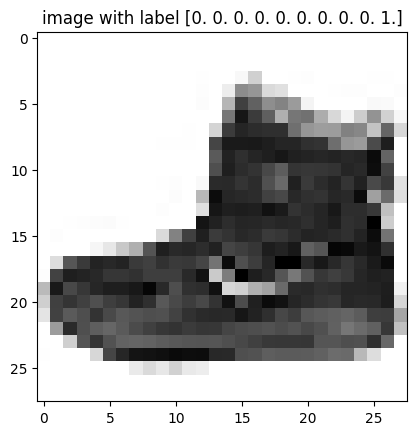

In [29]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

plt.figure()
plt.title(f"image with label {y_train[0]}")
plt.imshow(x_train[0].reshape(28, 28), cmap='Greys')
plt.show()

In [48]:
def leaky_relu(x):
    return tf.nn.leaky_relu(x, alpha=0.1)

def build_model_from_arch(
        arch,
        optimizer: Optimizer = tf.keras.optimizers.Adadelta(),
        loss: Loss = tf.keras.losses.categorical_crossentropy,
        metrics: List[str] = ["accuracy"],
        steps_per_execution: int = None,
    ):
    LAYER_DICT = {
        'dense': Dense,
        'dropout': Dropout,
        'conv': Conv2D,
        'maxpooling': MaxPooling2D,
        'flatten': Flatten,
    }
    model: Model = Sequential()
    model.add(Input(arch['shape'][0]))
    for (layer, kwargs) in arch['layers']:
        model.add(LAYER_DICT[layer](**kwargs))

    model.add(Dense(arch['shape'][1], activation = 'softmax'))
    model.compile(optimizer, loss, metrics, steps_per_execution)
    return model

mlp = {
    'shape': (784, 10),
    'layers': [
        ('dense', {'units': 512, 'activation': leaky_relu}),
        ('dropout', {'rate': 0.2}),
        ('dense', {'units': 512, 'activation': leaky_relu}),
        ('dropout', {'rate': 0.5}),
    ]
}

cnn = {
    'shape': ((28, 28, 1), 10),
    'layers': [
        ('conv', {'filters': 32,'kernel_size':(3, 3), 'activation': leaky_relu}),
        ('conv', {'filters': 64,'kernel_size':(3, 3), 'activation': leaky_relu}),
        ('maxpooling', {'pool_size': (2, 2)}),
        ('dropout', {'rate': 0.25}),
        ('flatten', {}),
        ('dense', {'units': 128, 'activation': leaky_relu}),
        ('dropout', {'rate': 0.5}),
    ]
}

MLP = build_model_from_arch(mlp, tf.keras.optimizers.Adam(), steps_per_execution = 100)

CNN = build_model_from_arch(cnn, tf.keras.optimizers.Adam(), steps_per_execution = 100)
# MLP: tf.keras.Model = build_mlp_model(x_train.shape[1], y_train.shape[1])
# # validation_split 0.1 is recommended for tuning hyper parameters
# MLP.fit(x_train, y_train, batch_size=128, epochs=20, validation_split = 0.1, use_multiprocessing = True)

In [ ]:
'''
Model contains: Architecture, Regularisations, Optimizer, Losses, (Metrics)
Testing may use: batch_size, epochs, validation_split (set at 0.1)
'''

def permute_fit_kwargses(
        batch_sizes: List[int] = [128],
        epochses: List[int] = [20],
        verbose: int = 0,
        validation_split: float = 0.1,
    ) -> List[Kwargs]:
    """Provided with a list of `batch_sizes`, a list of number of epochs `epochses` generate all possible permutations of the inputs.
    Will generate a list of the names, containing the specific kwargs"""
    kwargses: List[Kwargs] = []
    names: List[str] = []
    for batch_size in batch_sizes:
        for epochs in epochses:
            kwargses.append({
                "batch_size": batch_size,
                "epochs": epochs,
                "verbose": verbose,
                "validation_split": validation_split,
                })
            names.append(f"{batch_size=}, {epochs=}, {verbose=}, {validation_split=}")
    return kwargses, names

def print_arch(arch: Arch):
    result: str = ''
    for key, value in arch.items():
        result += f'arch.{key}={value}, '
    return result + '\n'

def permute_models(
    model_archs: List[Arch],
    optimizers: List[Optimizer],
    losses: List[Loss],
    metrics: List[str] = ["accuracy"],
    steps_per_execution: int = None,
    ) -> List[Model]:
    """Provided with a list of `model_archs`, a list of number of epochs `epochses` generate all possible permutations of the inputs.
    Will generate a list of the names, containing the specific kwargs"""
    models: List[Model] = []
    names: List[str] = []
    for arch in model_archs:
        for optimizer in optimizers:
            for loss in losses:
                models.append(build_model_from_arch(arch, optimizer(), loss, metrics, steps_per_execution))
                names.append(print_arch(arch) + f"{optimizer.__name__=}, {loss.__name__=}, {metrics=}, {steps_per_execution=}")
    return models, names

def print_best(performances: List[List], k: int = 5):
    sorted_k = sorted(performances, key = lambda x: x[-1], reverse = True)[:k]
    sorted_k = [ '[' + ', '.join(map(str, perf)) + ']' for perf in sorted_k]
    print(*sorted_k, sep='\n')

def run_all_tests(
    data: Data,
    models: List[Model],
    fit_kwargses: List[Kwargs],
    log: bool = True,
    show_k_best: bool = True,
    k: int = 5,
    ):
    if log:
        n_models = len(models)
        n_kwargs = len(fit_kwargses)
        n_tot = n_models * n_kwargs
        i = 1
        print(msg:=f"Will run {n_models} models, {n_kwargs} kwargs. {n_tot} total.")
        print("="*len(msg))

    if show_k_best:
        performances: List[List[int, int, float]] = []

    n_train = data['x_train'].shape[0]
    n_test = data['x_test'].shape[0]
    for m_id, model in enumerate(models):
        for f_id, fit_kwargs in enumerate(fit_kwargses):
            if log:
                print(f"Run {i} of {n_tot}: Model {m_id}, fit_kwargs {f_id}")
                model.summary()

            # fit each model on the same data with the same settings
            model.fit(data['x_train'].reshape(n_train, *model.input_shape[1:]),
                      data['y_train'], **fit_kwargs)

            # evaluate the fitted model
            score = model.evaluate(data['x_test'].reshape(n_test, *model.input_shape[1:]),
                                   data['y_test'], verbose = fit_kwargs['verbose'])
            metric_fmt = [f"\tMetric {name}: {s:.3f}" for s, name in zip(score, model.metrics_names)]
            performances.append([m_id, f_id, *[s for s, m in zip(score, model.metrics_names) if m == 'accuracy']])

            if log:
                print('\n'.join(metric_fmt), '\n')
                i += 1

    if show_k_best:
        print("Best performing: ")
        print_best(performances, k)

data = {
    'x_train': x_train,
    'y_train': y_train,
    'x_test': x_test,
    'y_test': y_test,
}

models, m_names = permute_models(
    model_archs= [mlp, cnn],
    optimizers = [tf.keras.optimizers.Adadelta,
                  tf.keras.optimizers.Adam,
                  tf.keras.optimizers.SGD],
    losses = [tf.keras.losses.categorical_crossentropy],
    steps_per_execution=100, # higher is quicker
)

kwargs, k_names = permute_fit_kwargses(
    batch_sizes = [64, 128, 256],
    epochses = [5, 10, 20],
    # verbose=1, # uncomment if you want to see the epochs in real time
)

run_all_tests(data, models, kwargs, log=False, show_k_best=True, k=5)


In [45]:
best = [
    [1, 0],
    [0, 0]
]

for m_id, k_id in best:
    print(m_names[m_id], k_names[k_id], sep = '\n', end='\n\n')

arch.shape=((28, 28, 1), 10), arch.layers=[('conv', {'filters': 32, 'kernel_size': (3, 3), 'activation': <function leaky_relu at 0x7f8cf4d42170>}), ('conv', {'filters': 64, 'kernel_size': (3, 3), 'activation': <function leaky_relu at 0x7f8cf4d42170>}), ('maxpooling', {'pool_size': (2, 2)}), ('dropout', {'rate': 0.25}), ('flatten', {}), ('dense', {'units': 128, 'activation': <function leaky_relu at 0x7f8cf4d42170>}), ('dropout', {'rate': 0.5})], 
optimizer.__name__='Adadelta', loss.__name__='categorical_crossentropy', metrics=['accuracy'], steps_per_execution=100
batch_size=256, epochs=5, verbose=0, validation_split=0.1

arch.shape=(784, 10), arch.layers=[('dense', {'units': 512, 'activation': <function leaky_relu at 0x7f8cf4d42170>}), ('dropout', {'rate': 0.2}), ('dense', {'units': 512, 'activation': <function leaky_relu at 0x7f8cf4d42170>}), ('dropout', {'rate': 0.5})], 
optimizer.__name__='Adadelta', loss.__name__='categorical_crossentropy', metrics=['accuracy'], steps_per_execution=

In [ ]:
# small test for the run function

def test_run():
    models, m_names = permute_models(
        model_archs= [mlp, cnn],
        optimizers = [tf.keras.optimizers.Adadelta],
        losses = [tf.keras.losses.categorical_crossentropy],
        steps_per_execution=100, # higher is quicker
    )

    kwargs, k_names = permute_fit_kwargses(epochses=[5])

    run_all_tests(data, models, kwargs)

test_run()

[]
Will run 1 models, 1 kwargs. 1 total.
Run 1 of 1: Model 0, fit_kwargs 0
	Metric loss: 0.629
	Metric accuracy: 0.745 

Best performing: 
[0, 0, 0.7447999715805054]
